In [1]:
import Pkg
Pkg.activate("../../../FinancialPlanner")

  Activating project at `c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner`


In [2]:
using Revise
using LinearAlgebra
using Distributions
using Random
using StatsPlots
using PDMats
using StatsBase
using Base.Iterators
using DataFrames, TimeSeries, XLSX
using PrettyTables

In [3]:
includet("../VARs/utils.jl")
includet("../VARs/VAR_OLS.jl")

In [4]:
df = DataFrame(XLSX.readtable("../../data/usa_macro_data.xlsx", "Quarterly", infer_eltypes=true))
data_source = collapse(TimeArray(df; timestamp = :observation_date), Dates.quarter, first)

display(returns_summarystats(data_source, 1)) 

,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
A939RX0Q048SBEA,14747.7,68696.0,40245.4,54126.5,18032.0,0.1437,27572.0,0.9887,-1.2415,2.7289,39691.0
GDPDEF,32.7932,125.532,57.1572,85.8735,13.675,0.1832,22.089,0.9889,-1.1966,1.743,57.826
TB3MS,3.068,15.05,4.2468,5.705,0.01,0.798,1.945,0.9729,0.9205,1.3842,4.23
GS10,2.8911,14.85,5.6289,7.365,0.65,0.854,3.63,0.9853,0.4842,1.947,4.98
Price_10Y,1693.98,5588.73,1619.78,2790.36,108.272,0.8096,182.663,0.9916,-0.8309,0.9562,799.867
Stock_Price,1155.26,5446.68,887.969,1284.31,36.79,1.8486,95.46,0.9678,3.0694,0.7686,330.45
Dividend,18.171,71.9758,17.0102,22.755,1.5533,1.4778,3.165,0.9818,1.2258,0.9361,10.9233
E,47.3465,197.883,40.6421,60.17,2.8333,1.6168,5.945,0.9754,2.0048,0.8584,17.8633
CAPE,8.0844,43.2083,20.9759,25.9614,6.6434,0.4623,15.5916,0.9796,-0.1197,2.5946,20.5076
USACPIALLQINMEI,35.7757,132.851,55.6431,86.7908,11.265,0.2901,17.6359,0.9887,-1.1685,1.5553,53.1045


nothing

In [5]:
data_source[:GDPDEF]

279×1 TimeArray{Float64, 1, Date, Vector{Float64}} 1955-01-01 to 2024-07-01
┌────────────┬─────────┐
│            │ GDPDEF  │
├────────────┼─────────┤
│ 1955-01-01 │  13.675 │
│ 1955-04-01 │  13.731 │
│ 1955-07-01 │  13.827 │
│ 1955-10-01 │  13.964 │
│ 1956-01-01 │  14.104 │
│ 1956-04-01 │  14.187 │
│ 1956-07-01 │  14.365 │
│ 1956-10-01 │  14.423 │
│     ⋮      │    ⋮    │
│ 2023-01-01 │ 121.251 │
│ 2023-04-01 │ 121.804 │
│ 2023-07-01 │ 122.768 │
│ 2023-10-01 │ 123.241 │
│ 2024-01-01 │ 124.163 │
│ 2024-04-01 │ 124.943 │
│ 2024-07-01 │ 125.532 │
└────────────┴─────────┘
        264 rows omitted

In [6]:
freq = 2

#cpi = (log.(data_source[:GDPDEF]) .- lag(log.(data_source[:GDPDEF]),4)) .* 100 
cpi = percentchange(data_source[:GDPDEF], :log) .* 400 
#gdp = (log.(data_source[:A939RX0Q048SBEA]) .- lag(log.(data_source[:A939RX0Q048SBEA]),4)) .* 100 
gdp = percentchange(data_source[:A939RX0Q048SBEA], :log) .* 400
sr = (data_source[:TB3MS]) .- cpi
term = (data_source[:GS10]) .- (data_source[:TB3MS])
#Δd = (log.(data_source[:Dividend]) .- lag(log.(data_source[:Dividend]),4)) .* 100 .- cpi
Δd = percentchange(data_source[:Dividend], :log) .* 400 .- cpi
dy = round.((log.(data_source[:Dividend]) .- log.(data_source[:Stock_Price])), digits=2)

data= merge(gdp, cpi, sr, term, Δd, dy)

start = Date(1985, 01,01)
end_d = Date(2024, 12, 31)
s_data = to(from(data, start),end_d)

display(returns_summarystats(s_data, freq)) 
display(cor(values(s_data)))



,std,max,mean,p75th,min,skewness,p25th,autocor,kurtosis,sr,median
A939RX0Q048SBEA,6.0164,59.9009,3.3826,5.9469,-66.4518,-1.8475,1.3285,-0.1304,38.9254,0.5622,3.986
GDPDEF,1.9368,17.9488,4.6456,5.6632,-2.954,1.4205,3.1557,0.7101,5.385,2.3987,4.3608
TB3MS_GDPDEF,3.7019,9.8805,1.7194,6.1288,-15.7888,-0.7304,-2.0289,0.9044,0.6654,0.4645,1.7707
GS10_TB3MS,1.7038,7.4,3.2803,5.31,-2.96,-0.299,1.48,0.9159,-0.6069,1.9253,3.3
Dividend_GDPDEF,9.6552,36.9042,6.746,14.95,-55.125,-1.563,0.6264,0.8828,5.0093,0.6987,7.8804
Dividend_Stock_Price,0.4537,-6.34,-7.7525,-7.19,-9.0,0.3421,-8.19,0.9538,-0.6936,-17.0866,-7.86


nothing

6×6 Matrix{Float64}:
  1.0           0.234325   -0.0536487  -0.000848978  -0.027606   -0.0954768
  0.234325      1.0        -0.327468   -0.101428      0.0424353  -0.0163428
 -0.0536487    -0.327468    1.0        -0.260891     -0.0190239   0.366906
 -0.000848978  -0.101428   -0.260891    1.0          -0.168612    0.402236
 -0.027606      0.0424353  -0.0190239  -0.168612      1.0         0.0200859
 -0.0954768    -0.0163428   0.366906    0.402236      0.0200859   1.0

In [7]:
s_data[:TB3MS_GDPDEF]

159×1 TimeArray{Float64, 1, Date, Vector{Float64}} 1985-01-01 to 2024-07-01
┌────────────┬──────────────┐
│            │ TB3MS_GDPDEF │
├────────────┼──────────────┤
│ 1985-01-01 │      4.24443 │
│ 1985-04-01 │      4.89447 │
│ 1985-07-01 │      4.70201 │
│ 1985-10-01 │      4.94023 │
│ 1986-01-01 │      4.91542 │
│ 1986-04-01 │        4.629 │
│ 1986-07-01 │      3.88372 │
│ 1986-10-01 │       3.1761 │
│     ⋮      │      ⋮       │
│ 2023-01-01 │      1.00458 │
│ 2023-04-01 │      3.24983 │
│ 2023-07-01 │      2.13672 │
│ 2023-10-01 │      3.74184 │
│ 2024-01-01 │      2.24863 │
│ 2024-04-01 │      2.73503 │
│ 2024-07-01 │      3.10877 │
└────────────┴──────────────┘
             144 rows omitted

In [8]:
data_source[:TB3MS]

279×1 TimeArray{Float64, 1, Date, Vector{Float64}} 1955-01-01 to 2024-07-01
┌────────────┬───────┐
│            │ TB3MS │
├────────────┼───────┤
│ 1955-01-01 │  1.22 │
│ 1955-04-01 │  1.48 │
│ 1955-07-01 │  1.86 │
│ 1955-10-01 │  2.34 │
│ 1956-01-01 │  2.33 │
│ 1956-04-01 │  2.57 │
│ 1956-07-01 │  2.58 │
│ 1956-10-01 │  3.03 │
│     ⋮      │   ⋮   │
│ 2023-01-01 │  4.63 │
│ 2023-04-01 │  5.07 │
│ 2023-07-01 │  5.29 │
│ 2023-10-01 │  5.28 │
│ 2024-01-01 │  5.23 │
│ 2024-04-01 │  5.24 │
│ 2024-07-01 │  4.99 │
└────────────┴───────┘
      264 rows omitted

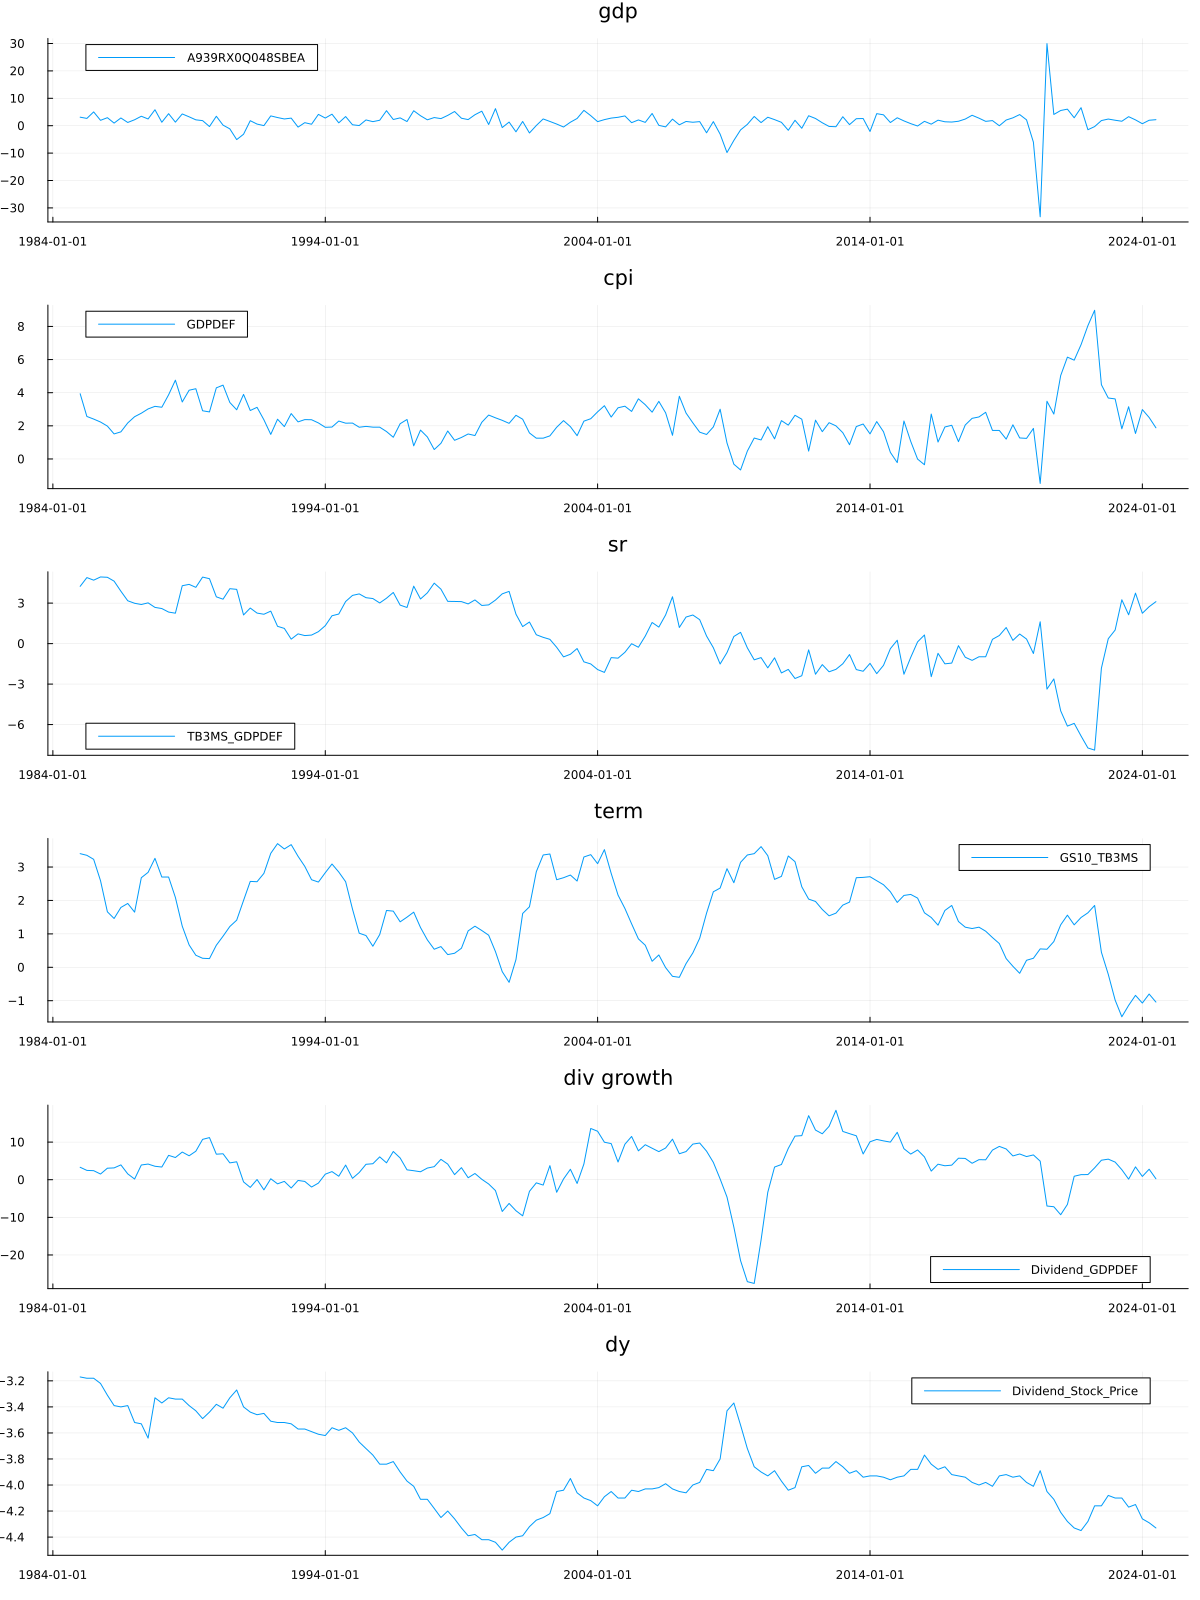

In [9]:
plot(s_data; layout = (6,1), size=(1200,1600), title=["gdp" "cpi" "sr" "term" "div growth" "dy"])

In [10]:
assets_names = colnames(s_data)
T, n_assets = size(s_data)
model = VARModel(s_data)
model_summary(model)

,const,A939RX0Q048SBEA,GDPDEF,TB3MS_GDPDEF,GS10_TB3MS,Dividend_GDPDEF,Dividend_Stock_Price,std
A939RX0Q048SBEA,-5.77,-0.135,-0.0078,0.2198,0.3983,0.0048,-1.7649,4.2649
GDPDEF,0.4868,-0.0149,0.7154,-0.0057,-0.0273,-0.0012,-0.0623,0.9709
TB3MS_GDPDEF,-1.0083,0.0256,0.3437,0.9773,0.057,0.0095,-0.0132,0.9784
GS10_TB3MS,0.7431,-0.005,-0.064,-0.0161,0.9049,-0.0129,0.103,0.4078
Dividend_GDPDEF,-8.3006,0.182,0.5098,0.0041,0.5456,0.9009,-1.6051,2.9745
Dividend_Stock_Price,-0.3715,-0.0018,0.0161,0.0034,0.019,0.0027,0.9261,0.0653


,A939RX0Q048SBEA,GDPDEF,TB3MS_GDPDEF,GS10_TB3MS,Dividend_GDPDEF,Dividend_Stock_Price
A939RX0Q048SBEA,1.0,0.42,-0.27,-0.1,0.01,-0.39
GDPDEF,0.42,1.0,-0.91,0.12,-0.21,-0.23
TB3MS_GDPDEF,-0.27,-0.91,1.0,-0.34,0.2,0.13
GS10_TB3MS,-0.1,0.12,-0.34,1.0,0.01,0.18
Dividend_GDPDEF,0.01,-0.21,0.2,0.01,1.0,0.05
Dividend_Stock_Price,-0.39,-0.23,0.13,0.18,0.05,1.0


In [20]:
freq = 4
scenarios = simulate(model, 25*freq, 10_000)
#periods = [2,6, 16, 26]
periods_years = [1,5, 15, 25]

scenarios_years = scenarios[:,periods_years .*freq,:]



6×4×10000 Array{Float64, 3}:
[:, :, 1] =
  6.59929   -0.453086   4.6417    -0.539831
  2.56926    3.63968    3.10901    4.64111
  2.83796    1.9709    -0.664825   1.62046
 -0.695203   1.6761     2.21619   -0.425859
  2.3393     9.82806   -3.82353   -2.92411
 -4.57121   -4.39554   -4.03715   -3.82778

[:, :, 2] =
  5.42079    2.76793   1.58527   -1.76399
  1.95345    4.4904    2.2052     3.75597
  1.74151   -1.23733   0.942937   2.06317
  0.269624   1.30029   2.43611   -0.747191
  3.66455    7.10635   7.4475     7.2243
 -4.41035   -4.51814  -4.28716   -4.33452

[:, :, 3] =
  0.872242  -0.234987   -10.1775    5.89535
  2.99011    5.62639     -1.10727   3.8347
  1.53564    0.341537     3.07386  -2.26328
 -1.23839    0.229447     1.83589   3.38125
 -0.203548   0.0641586   -7.65539   0.169455
 -4.48007   -4.0785      -3.67429  -3.75245

;;; … 

[:, :, 9998] =
  1.31744    2.41949   -4.77927    -4.30682
  1.84099    2.71195    0.0773257   3.71843
  3.25239   -0.422961   3.34659    -1.03442
 

In [21]:
percentile(scenarios[3,5,:], [.25,.5,.75])

3-element Vector{Float64}:
 -1.54138424311071
 -1.2938232026800953
 -1.0598424504771244

In [62]:
periods = periods_years.*freq .+1

cpi = cumsum(scenarios[2,:,:] ./ 4,dims=1)[periods,:] ./periods_years
#sr = scenarios[2,:,:] + scenarios[3,:,:]
sr = cumsum(scenarios[3,:,:] ./ 4,dims=1)[periods,:] ./periods_years .+ cpi
lr = cumsum(scenarios[4,:,:] ./ 4,dims=1)[periods,:] ./periods_years .+ cpi .+ sr
Δd = cumsum(scenarios[5,:,:] ./ 4,dims=1)[periods,:] ./periods_years .+ cpi
dy = exp.(scenarios[6, :,:])


eq_return = calculate_equity_returns(scenarios[2,:,:] ./ 4 .+  scenarios[5,:,:] ./ 4, scenarios[6, :,:])

eq_return_cum = (cumsum(eq_return,dims=1)[periods_years.*freq,:] ./periods_years) .* 100
real_eq_return =  eq_return_cum .- cpi 
#real_eq_return_cum = cumsum(real_eq_return, dims=1)[periods_years,:] ./periods_years
#= bond_returns = calculate_bond_returns(lr ./100, 10, 1)
bond_cum_returns = cumsum(log.(bond_returns .+1), dims=1)[periods,:] ./ periods_years  =#



print_scenarios_percentiles(cpi, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "cpi")
print_scenarios_percentiles(sr, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "sr")
print_scenarios_percentiles(lr, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "lr")
print_scenarios_percentiles(Δd, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "div growth")
print_scenarios_percentiles(dy[periods,:], [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "dy")
print_scenarios_percentiles(eq_return_cum, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "equity")
print_scenarios_percentiles(real_eq_return, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "real equity")
#print_scenarios_percentiles(bond_cum_returns, [.01, 0.025, .05, .25, .5, .75, .95, .975, .99], string.([1, 5, 10, 25]), "bonds")



,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,0.5045,0.8545,1.1673,2.0839,2.7266,3.3591,4.301,4.6134,4.9409
5,0.9486,1.1962,1.4212,2.0887,2.5401,3.0042,3.6754,3.8908,4.1482
10,1.4589,1.6295,1.7509,2.1753,2.4781,2.7697,3.1927,3.3265,3.4982
25,1.6426,1.775,1.8886,2.2118,2.4459,2.6816,3.0159,3.1159,3.244


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,4.536,4.7198,4.8975,5.4641,5.8394,6.2285,6.7986,6.9841,7.1937
5,1.7439,2.198,2.5289,3.5946,4.3497,5.0971,6.1832,6.5451,6.9461
10,0.78,1.2323,1.646,2.909,3.7814,4.6706,5.9395,6.3868,6.8421
25,0.6109,1.0515,1.4478,2.6601,3.509,4.3593,5.5871,6.022,6.4294


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,4.8127,5.2817,5.6911,6.9032,7.7573,8.5916,9.8168,10.2332,10.7502
5,3.7993,4.3194,4.7443,6.0322,6.9416,7.8329,9.1232,9.4951,9.9873
10,3.7699,4.2565,4.6667,5.8658,6.7086,7.5246,8.7266,9.1038,9.5853
25,3.9599,4.4075,4.7419,5.8269,6.5888,7.3222,8.4191,8.7566,9.1947


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-6.6583,-5.3069,-3.9959,-0.4408,2.1663,4.7789,8.56,9.8355,11.2594
5,-4.7675,-3.4582,-2.0221,1.7897,4.4722,7.1832,10.9474,12.2089,13.8904
10,0.4652,1.3557,2.1517,4.4615,6.0421,7.6398,9.9602,10.6446,11.4089
25,1.9253,2.5979,3.2549,4.9961,6.2415,7.5049,9.2297,9.8357,10.6039


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,0.009,0.0094,0.0098,0.011,0.012,0.0131,0.0147,0.0153,0.016
5,0.0071,0.0078,0.0086,0.011,0.0131,0.0157,0.0201,0.0218,0.024
10,0.0077,0.0087,0.0095,0.0127,0.0155,0.019,0.0254,0.0278,0.0308
25,0.008,0.0089,0.0098,0.0131,0.0161,0.0198,0.0263,0.0289,0.0326


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-12.3778,-7.7028,-4.0902,7.527,15.7032,24.0863,35.7866,39.3529,44.1452
5,-2.068,-0.4829,1.02,6.0063,9.4759,12.8338,17.6525,19.2656,21.0982
10,4.4304,5.3472,6.148,8.7321,10.6544,12.49,15.1335,16.0239,16.9965
25,6.6527,7.3943,8.0503,10.0335,11.4495,12.8854,15.0338,15.6506,16.4461


,0.01,0.025,0.05,0.25,0.5,0.75,0.95,0.975,0.99
1,-15.1968,-10.5652,-6.8527,4.8565,13.0028,21.408,32.9397,36.5437,41.4641
5,-4.8035,-2.9567,-1.5034,3.4432,6.9283,10.3072,15.0728,16.7748,18.4976
10,2.0365,2.9701,3.748,6.3285,8.1633,9.9609,12.5431,13.4731,14.4349
25,4.2142,5.0465,5.6286,7.6047,9.0318,10.4155,12.5529,13.1943,13.9703


In [63]:
mdd, mddl = max_drawdown_and_length(eq_return)

display(" equity")
display("mdd")
display(quantile(mdd, [.03, .25, .5, .75, .97])')
display("mddl")
display(quantile(mddl, [.03, .25, .5, .75, .97])')

" equity"

"mdd"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 0.143421  0.20034  0.243007  0.2959  0.419213

"mddl"

1×5 adjoint(::Vector{Float64}) with eltype Float64:
 7.0  11.0  15.0  20.0  33.0

In [15]:
B = collect(model.C[2:end,:]')

resp = girf(B, model.Σ, 8, 2)

plot(resp; layout = (6,1), size=(1200,1600), title=["gdp" "cpi" "sr" "term" "div growth" "dy"])

MethodError: MethodError: no method matching girf(::Matrix{Float64}, ::Matrix{Float64}, ::Int64, ::Int64)
The function `girf` exists, but no method is defined for this combination of argument types.

Closest candidates are:
  girf(::Matrix{Float64}, ::Matrix{Float64}, ::Int64, ::Int64, !Matched::Any)
   @ Main c:\Users\matsz\programowanie\Optymalizacja_portfela\FinancialPlanner\_wip\VARs\utils.jl:213


In [16]:
display(exp(-3.8 ) *100) 
display(exp(-3.8 + 0.08)*100) 
display((exp(-3.8 ) - exp(-3.8 + 0.08))*100) 
display(0.0224*exp((0.06^2)-1)^.5 *100)
display(exp(-4.8 ) *100) 

2.23707718561656

2.4233967845691122

-0.1863195989525522

1.3610764116758998

0.822974704902003

IRF returns
- estimate dy, and div idnex, based on initial value, mean?
- estimate returns?
- 

In [17]:
resp

UndefVarError: UndefVarError: `resp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [18]:
real_Δd = resp[:,2] + resp[:,5]




UndefVarError: UndefVarError: `resp` not defined in `Main`
Suggestion: check for spelling errors or missing imports.

In [19]:
dy = exp.(scenarios[6, :,:])

101×10000 Matrix{Float64}:
 0.0131675  0.0131675   0.0131675  …  0.0131675   0.0131675  0.0131675
 0.0138117  0.0111889   0.0142293     0.0127871   0.0122147  0.0134403
 0.0150932  0.0100431   0.0136491     0.0118723   0.0118727  0.0132
 0.0148073  0.00965645  0.0157281     0.0116523   0.0104078  0.0141433
 0.0156748  0.0106441   0.0149121     0.0107348   0.0109066  0.013959
 0.0161469  0.0107021   0.0143254  …  0.0103671   0.0121007  0.0151361
 0.0158771  0.0115424   0.0144173     0.0100399   0.0125541  0.0147917
 0.0158524  0.0112987   0.0136307     0.00970155  0.012689   0.0140873
 0.016337   0.010035    0.0134825     0.00938997  0.0127578  0.0133858
 0.015185   0.0100984   0.0133088     0.0105164   0.0142458  0.0137439
 ⋮                                 ⋱                         
 0.0214967  0.0190873   0.0155214     0.0232066   0.0211968  0.01309
 0.0200827  0.0173166   0.014955      0.0225875   0.0198361  0.0151277
 0.0190682  0.0168075   0.0152128     0.023059    0.0166752  0.01